## Summary of the notebook 

Flipout model trained in the notebook : GBP_CHD_flipout_training.ipynb

**train configuration**
eager execution = enabled 

**process**
1. Load the flipout trained model from the path 
2. Pass this model and the number of samples desired (to compute the prediction mean and prediction std) to the StochasticRegressor class 
3. The StochasticRegressor returns a stochastic model that can yield prediction mean and prediction std 
4. Using the model obtained in 3., we call the predict_output() that returns prediction mean, prediction std and the predicted samples themselves (from which this mean and std has been calculateed) 
5. Plot these predition mean and prediction std against the ground truth to check the stochastic behaviour of the model 
6. Fix a number for how many sample explanations are needed for a given input. For this many number of samples, run a loop. Every time the explanation method is called, it returns the explanation (gradient of output wrt input) for that particular sample (essentially the input is same however, the model regression output differs everytime)  of shape (1, 8) and the sample prediction itself (1,1)
7. Using the sample explanation (of shape (1, 8)), for say 20 samples of flipout (yields an explanation matrix of (20, 8)) ,compute the mean explanation (shape (1, 8)) and the std dev explanation (shape (1, 8)). From the 20 samples prediction themselves (20, 1) compute the mean prediction (1, 1) and std dev prediction (1, 1) 

**checks** 
ensure that the layers for which the GBP is being computed are relevant/correct  [should be the layer which yields the regression output]




## Mount the drive

In [1]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')


import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
print(tf.executing_eagerly())

Mounted at /content/drive
True


## Setting the correct path

In [2]:
import os

project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'flipout'

%cd /content/drive/MyDrive/MasterThesis/ 

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print(path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/


## Removing the previous plots and explanations

In [3]:
import glob, os, os.path
output_plot_path = path+'output_plots/'
filelist_pdf = glob.glob(os.path.join(output_plot_path, '*.pdf'))
filelist_png = glob.glob(os.path.join(output_plot_path, '*.png'))

# removing pdf explanatiosn 
for f in filelist_pdf:
    print(f'removing file {f}')
    os.remove(f)

for f in filelist_png:
    print(f'removing file {f}')
    os.remove(f)

removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/flipout_vs_prediction.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_0_input_id_1360.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_1_input_id_1360.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_2_input_id_1360.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_3_input_id_1360.pdf
removing file /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/output_plots/explanation_for_sample_number_4_input_id_1360.pdf
removing file /content

## Imports

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf

import os
import random 
import math

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

2.8.0
Eager execution enabled : True


## Load Data

In [5]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()

# following code to test the replicability of data split
#print(train_labels[20])
#print(val_labels[30])
#print(test_labels[40])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## Class and distribution definitions

### StochasticModel & StochasticRegressor

In [6]:
import numpy as np
import tensorflow as tf 
import tensorflow.keras.backend as K

Layer = tf.keras.layers.Layer
Dropout = tf.keras.layers.Dropout


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)

class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10):
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output

    def predict_output(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        print('Intermediate sample shape ', samples.shape)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)

        return samples, mean_pred, std_pred    


    def predict(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)

        return mean_pred, std_pred    


    def get_layer(self, name=None, index=None):
        # the get_layer() has been taken from ths following source 
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

### Gaussian and Rademacher distribution

In [7]:
# rademacher 
import tensorflow.keras.backend as K

def sample(shape):
    samples = K.random_binomial(shape, p=0.5)

    return 2.0 * samples - 1.0


# gaussian 
import numpy as np
import math

NegHalfLog2PI = -0.5 * math.log(2.0 * math.pi)
InvSqrt2PI = 1.0 / (math.sqrt(2.0 * math.pi))

def log_probability(x, mu, sigma):
    return NegHalfLog2PI - K.log(sigma) - 0.5 * K.square((x - mu) / sigma)

def probability(x, mu, sigma):
    x= K.square((x - mu) / sigma)

    return InvSqrt2PI * (1.0 / sigma) * K.exp(-0.5 * x)

class GaussianDistribution:
    def __init__(self, mean, std, shape):
        self.mean = mean
        self.std = std
        self.shape = shape

    def sample(self):
        return K.random_normal(self.shape, self.mean, self.std)

    def sample_perturbation(self):
        return K.random_normal(self.shape, K.zeros(self.shape), self.std)

    def log_probability(self, x):
        return NegHalfLog2PI - K.log(self.std) - 0.5 * K.square((x - self.mean) / self.std)

### FlipoutDense

In [8]:
import numpy as np
import tensorflow
import keras
Layer = tensorflow.keras.layers.Layer
activations = tensorflow.keras.activations
initializers = keras.initializers

#from keras_uncertainty.distributions import gaussian, rademacher

# Code partially based on http://krasserm.github.io/2019/03/14/bayesian-neural-networks/

class FlipoutDense(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 initializer_sigma=0.1,
                 prior=True,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5,
                 prior_pi_1=None,
                 bias_distribution=False,
                  **kwargs):
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior = prior
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.initializer_sigma = initializer_sigma
        self.uses_learning_phase = True
        self.bias_distribution = bias_distribution

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return [(None, self.units)]

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.initializer_sigma),
                                         trainable=True)
        
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                          trainable=True)

        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.initializer_sigma),
                                       trainable=True)

        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                        trainable=self.bias_distribution)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = K.softplus(self.kernel_rho)
        kernel_perturb = kernel_sigma * K.random_normal(self.kernel_mu.shape)
        kernel = self.kernel_mu + kernel_perturb

        if self.bias_distribution:
            bias_sigma = K.softplus(self.bias_rho)
            bias = self.bias_mu + bias_sigma * K.random_normal(self.bias_mu.shape)
        else:
            bias = self.bias_mu

        loss = self.kl_loss(kernel, self.kernel_mu, kernel_sigma)

        if self.bias_distribution:
            loss += self.kl_loss(bias, self.bias_mu, bias_sigma)

        self.add_loss(K.in_train_phase(loss, 0.0))

        input_shape = K.shape(inputs)
        batch_shape = input_shape[:-1]
        sign_input = sample(input_shape)
        sign_output = sample(K.concatenate([batch_shape, K.expand_dims(self.units, 0)], axis=0))
        perturbed_inputs = K.dot(inputs * sign_input, kernel_perturb) * sign_output

        outputs = K.dot(inputs, self.kernel_mu)
        outputs += perturbed_inputs
        outputs += bias

        # This always produces stochastic outputs
        return self.activation(outputs)

    def kl_loss(self, w, mu, sigma):
        return self.kl_weight * K.mean(log_probability(w, mu, sigma) - self.prior * self.log_prior_prob(w))

    def log_prior_prob(self, w):
        return K.log(self.prior_pi_1 * probability(w, 0.0, self.prior_sigma_1) +
                     self.prior_pi_2 * probability(w, 0.0, self.prior_sigma_2))

    def get_config(self):
        config = {'units': self.units,
                  'kl_weight': self.kl_weight,
                  'activation': self.activation.__name__,
                  #'bias': self.bias,
                  'prior': self.prior,
                  'prior_sigma_1': self.prior_sigma_1,
                  'prior_sigma_2': self.prior_sigma_2,
                  'prior_pi_1': self.prior_pi_1}
        base_config = super(FlipoutDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Load the saved model

In [9]:
# error if the custom object containing the stochastic dropout model not passed (Unknown layer: StochasticDropout. Please ensure this object is passed to the `custom_objects` argument)

import os
test = os.listdir(path)

for item in test:
    if item.endswith('.h5'):
        print('model name : ', item)
        
        #model_file = '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/'+item
        #model.load_weight(model_file)
        model = tf.keras.models.load_model(path+item,
                                           custom_objects={'FlipoutDense':FlipoutDense})
#this model has been trained on the chd_regression_training notebook
#model = tf.keras.models.load_model('/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/training/results/dropout/model.h5', custom_objects={'StochasticDropout':StochasticDropout}) 
model.summary()

model name :  flipout_model_epochs_500_num_samples_20.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flipout_dense (FlipoutDense  (None, 32)               576       
 )                                                               
                                                                 
 flipout_dense_1 (FlipoutDen  (None, 32)               2112      
 se)                                                             
                                                                 
 flipout_dense_2 (FlipoutDen  (None, 16)               1056      
 se)                                                             
                                                                 
 flipout_dense_3 (FlipoutDen  (None, 16)               544       
 se)                                                             
                                                                 
 flipout_dense_4 (FlipoutDen  (None, 1)                3

## Ground Truth vs prediction plot

In [10]:
# Analysis of the input 
num_of_inputs_to_be_explained = 1

start_index = np.random.randint(0, test_data.shape[0])
print('start_index : ', start_index)

test_input = test_data[start_index:start_index+num_of_inputs_to_be_explained]
print('test_input shape :', test_input.shape)

test_input_adj = np.expand_dims(test_input, axis=-1)
print('test_input_adj shape :', test_input_adj.shape)

# MODEL PREDICTION AND PLOTTING 
stochastic_model = StochasticRegressor(model)
pred_samples, pred_mean, pred_std = stochastic_model.predict_output(test_data, num_samples=5)
print('pred samples shape ', pred_samples.shape)
print('pred mean shape ', pred_mean.shape)
print('pred std shape ', pred_std.shape)

print('pred samples : \n', pred_samples)
print('pred mean : \n', pred_mean)
print('pred std : \n', pred_std)

start_index :  1545
test_input shape : (1, 8)
test_input_adj shape : (1, 8, 1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


Intermediate sample shape  (5, 3000, 1)
pred samples shape  (5, 3000, 1)
pred mean shape  (3000, 1)
pred std shape  (3000, 1)
pred samples : 
 [[[0.6585087 ]
  [0.30195373]
  [0.48365182]
  ...
  [0.18323848]
  [0.24164641]
  [1.0669297 ]]

 [[0.65930945]
  [0.44972283]
  [0.52154016]
  ...
  [0.1826478 ]
  [0.30598456]
  [0.88100165]]

 [[0.82320136]
  [0.4071285 ]
  [0.4638843 ]
  ...
  [0.18628901]
  [0.2717725 ]
  [1.1699237 ]]

 [[0.469688  ]
  [0.34858543]
  [0.59425867]
  ...
  [0.17835683]
  [0.27299404]
  [0.94699496]]

 [[0.78417367]
  [0.3840593 ]
  [0.5973079 ]
  ...
  [0.18786089]
  [0.27068713]
  [1.0115563 ]]]
pred mean : 
 [[0.67897624]
 [0.37828997]
 [0.5321286 ]
 ...
 [0.1836786 ]
 [0.27261692]
 [1.0152812 ]]
pred std : 
 [[0.12367267]
 [0.05035312]
 [0.05518675]
 ...
 [0.00328278]
 [0.02038211]
 [0.0992872 ]]


start index 
  154
random 
  range(0, 100)
test labels plot 
  [0.67476298 0.32251241 0.51937064 0.64397771 0.1239788  0.09319352
 0.09319352 0.30240774 0.35999925 0.29675331 0.21465924 0.07497366
 0.48188381 0.43706715 0.41884729 0.27350728 0.33256475 0.24083719
 0.58115062 0.82052184 0.21738174 0.127539   0.45863778 0.19455457
 0.26848111 0.96795609 0.47643879 0.72607178 0.68586244 0.84293017
 0.17403105 0.31434489 0.22282676 0.24984241 0.33780034 0.32711973
 0.51999891 0.34094169 0.24921414 0.43916138 0.12732958 0.5287947
 1.         0.11895263 0.40272167 0.45026084 0.39790493 0.17424047
 0.21214615 0.3170674  0.28984232 0.05235591 0.28062768 0.34554901
 0.35455423 0.32104645 0.14534001 0.36523484 0.56481557 0.35978982
 0.55895171 0.43266925 0.50889946 0.11581128 0.55937056 0.56314018
 0.22366445 0.44188389 0.20565402 0.31790509 0.5801035  0.21465924
 0.39790493 0.61654321 0.28230307 0.28942348 0.33633437 0.45151738
 0.63539134 0.87266833 0.24083719 0.39790493 0.3214653  0.21738174


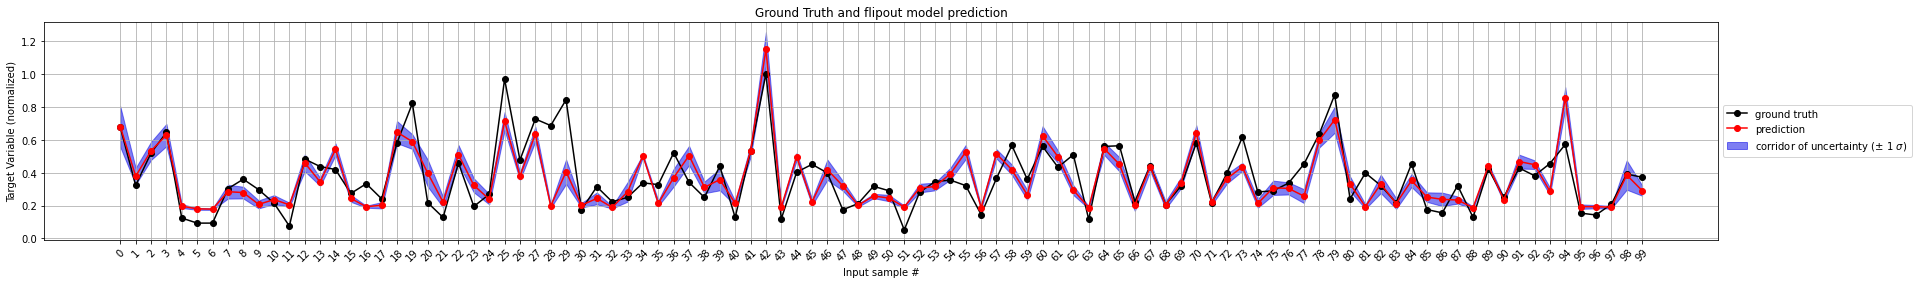

In [11]:

start_index = np.random.randint(test_data.shape[0]-150)
print('start index \n ', start_index)

#random = range(start_index, start_index+100)
random=range(0, 100)
print('random \n ', random) 

test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
print('test labels plot \n ', test_labels_plot)

mean_plot = np.asarray([float(pred_mean[i]) for i in random])
std_plot = np.asarray([float(pred_std[i]) for i in random])

print('unique value of predicted standard deviation \n ', np.unique(std_plot))

plot_gt_vs_pred(test_labels_plot, mean_plot, std_plot, path+'output_plots/'+uncert_name+'_vs_prediction', random, uncert_name)

## Compute GBP explanation

In [12]:
def gbp_explanation(test_input, test_label, layer_name, model, num_samples_explanations_to_be_generated, sample_id):
    @tf.custom_gradient
    def guidedRelu(x):
        #https://towardsdatascience.com/how-to-visually-explain-any-cnn-based-models-80e0975ce57
        def grad(dy):
            return tf.cast(dy>0,'float32') * tf.cast(x>0, 'float32') * dy
        return tf.nn.relu(x), grad

    
    LAYER_NAME = layer_name

    # create a model till last convolutional layers to have the best compromise between high-level semantics and detailed spatial information
    gb_model = tf.keras.models.Model(inputs = [model.input],    
                                     outputs = [model.get_layer(LAYER_NAME).output])
    
    print('list of gbp_model layer name : ')
    for i in gb_model.layers:
        print('layer_name_ ', i.name)
    
    layer_dict = [layer for layer in gb_model.layers[1:] if hasattr(layer,'activation')]
    

    #value = model.get_layer(LAYER_NAME).output.shape[-1]  # to compute the number of channels in the volume at a particular layer 

    for layer in layer_dict:
        if layer.activation == tf.keras.activations.relu:
            layer.activation = guidedRelu

    feature_weight_list = [] 
    list_of_outputs = []

    for i in range(num_samples_explanations_to_be_generated):
        print('xxxxxxxxxxxxxxxxxxxxxxxxxx')
        print('Example to be explained : ' , test_input)
        with tf.GradientTape() as tape:
            inputs = tf.cast(test_input, tf.float32)
            tape.watch(inputs)
            # NO NEED TO RUN THIS (the if condition) AS VISUALIZATION OF ENSEMBLE HEATMAPS FOR INNER LAYER WOULD MAKE NO SENSE : FILTER IN EVERY INDIVIDUAL ENSEMBLE UNIT WOULD LEARN SOMETHING DIFFERENT EVERYTIMG
            # THIS THESIS NEEDS TO FOCUS ON FINAL LAYER HEATMAPS (AS THEY SHOULD BE SAME FOR A GIVEN INPUT ACROSS ENSEMBLES)
                    
            #outputs = gb_model.predict(inputs) 
            outputs = gb_model(inputs)
            list_of_outputs.append(outputs)
            # essentially model() and model.predict() yield the same output with the difference that 
            # https://stackoverflow.com/questions/55308425/difference-between-modelx-and-model-predictx-in-keras#:~:text=The%20format%20may%20be%20different,its%20structure%2C%20weights%20and%20biases.
            #Today given a model in tensorflow 2.0 (built using the keras library), #out_np = model.predict(x) provides a numpy array which can, as an example, be printed with print(out_np).
            #On the other hand,out_tf = model(x) results into a tensorflow object, wich can be converted to a numpy array with .numpy()

    
            print('feature_names ', feature_names)
            print('outputs ', outputs)

        grads = tape.gradient(outputs, inputs)[0]# selecting that unit in dense layer that has the maximum activation for a given input,,,, if[0] not selected then shape of grads is: [1,32,32,3] 
        print('grads ', grads)

        grads = grads.numpy() #as the model(inputs) returns a tensor and this is eventually used in the gradient computation, for plotting purpose this needs to be converted in np

        # normalizing the value of computed gradient for each feature [04032022 update : no need to normalize the gradients as it is only useful for visualization in heatmap ]
        # in bar charts, the gradients can remain negative 
        #grads -= np.min(grads)
        #grads /= np.max(grads)
        
        print('normalized_grads : ', grads)
        feature_weight_list.append(grads)
        plot_explanation(grads_plot=grads, 
                         feature_names=feature_names,
                         sample_number=i, 
                         err=None, 
                         save_file_path=path+'output_plots/explanation_for_sample_number_'+str(i)+'_input_id_'+str(sample_id))   
    
    print('feature_weight_list : ', feature_weight_list)
    feature_weight_arr =  np.asarray(feature_weight_list)
    feature_weight = np.reshape(feature_weight_arr, (num_samples_explanations_to_be_generated, -1))
    # the mean and the std of the different explanations of the samples is computed here 
    mean_feature_weight = np.mean(feature_weight_arr, axis=0)
    std_feature_weight = np.std(feature_weight_arr, axis=0)

    #print(mean_feature_weight)
    #print(std_feature_weight)

    
    print('len of outputs : ', len(list_of_outputs))
    print('test_label ', test_label)
    mean_output = np.mean(list_of_outputs)
    std_output = np.std(list_of_outputs)

    mean_output = str(round(mean_output, 3))
    std_output = str(round(std_output, 3))
    test_label = str(round(float(test_label), 3))

    print('mean_output ', mean_output)
    print('std_output ', std_output)
    #print('test_label ', test_label)
    print('test_label ', test_label)
    
    plot_explanation(grads_plot=mean_feature_weight, 
                     feature_names=feature_names,
                     sample_number=None, 
                     err=std_feature_weight,
                     save_file_path=path+'output_plots/combined_explanation_of_'+str(num_samples_explanations_to_be_generated)+'_samples_for_input_id_'+str(sample_id),
                     combination_title=[mean_output, std_output, test_label])
    
    return mean_feature_weight, std_feature_weight

train data 
  [0.19023398 0.55579171 1.         0.10391459 0.16620112 0.05353289
 0.15984213 0.16943215]
feature names 
  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
test_input shape : (1, 8)
test label shape :  (1,)
list of gbp_model layer name : 
layer_name_  flipout_dense_input
layer_name_  flipout_dense
layer_name_  flipout_dense_1
layer_name_  flipout_dense_2
xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.11142401 0.         0.         0.
  0.         0.         0.         0.         0.10162815 0.06767174
  0.         0.17430449 0.         0.1

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.05987078 0.0358054  0.         0.
  0.         0.         0.         0.01425637 0.01627544 0.
  0.         0.27366096 0.         0.04943879]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-0.88236064 -1.1558634   0.6674801   0.47685102  0.5637207  -1.4768591
  1.045536    2.6199732 ], shape=(8,), dtype=float32)
normalized_grads :  [-0.88236064 -1.1558634   0.6674801   0.47685102  0.5637207  -1.4768591
  1.045536    2.6199732 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.1539311  0.00221016 0.         0.
  0.         0.00044794 0.         0.         0.17329095 0.0405857
  0.         0.264312   0.         0.15797734]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-1.963068   -2.2028003   1.2627062   0.94866014  1.5798253  -1.8667517
  1.8740487   4.043788  ], shape=(8,), dtype=float32)
normalized_grads :  [-1.963068   -2.2028003   1.2627062   0.94866014  1.5798253  -1.8667517
  1.8740487   4.043788  ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.08745596 0.00497504 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.27390832 0.         0.01686168]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-0.6632903  -0.6013825   0.40998062  0.5440632   0.47978157 -0.88513404
  0.21063718  1.4750338 ], shape=(8,), dtype=float32)
normalized_grads :  [-0.6632903  -0.6013825   0.40998062  0.5440632   0.47978157 -0.88513404
  0.21063718  1.4750338 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.07390313 0.04702256 0.         0.
  0.         0.         0.05212901 0.         0.1705624  0.04665448
  0.         0.41353387 0.         0.17948362]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-1.9565383 -2.0883517  1.3007692  0.544661   1.6148145 -1.8308767
  1.1816053  3.6175065], shape=(8,), dtype=float32)
normalized_grads :  [-1.9565383 -2.0883517  1.3007692  0.544661   1.6148145 -1.8308767
  1.1816053  3.6175065]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.11602215
  0.         0.1537355  0.         0.02950125]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-0.34358925 -0.46178222  0.25055572  0.26814753  0.11974104 -0.29520002
  0.31134462  0.6016973 ], shape=(8,), dtype=float32)
normalized_grads :  [-0.34358925 -0.46178222  0.25055572  0.26814753  0.11974104 -0.29520002
  0.31134462  0.6016973 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.02945647 0.         0.1653158  0.07460084 0.         0.
  0.         0.         0.06165994 0.         0.16125718 0.00465994
  0.         0.34302393 0.         0.21776506]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-3.845371  -3.9069066  2.4252694  1.3882648  3.5262337 -6.6129174
  4.487353   9.503409 ], shape=(8,), dtype=float32)
normalized_grads :  [-3.845371  -3.9069066  2.4252694  1.3882648  3.5262337 -6.6129174
  4.487353   9.503409 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.05086491 0.         0.18080209 0.12684    0.         0.
  0.         0.         0.         0.         0.16542764 0.
  0.         0.37016338 0.         0.26481676]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-2.787128  -2.8260238  1.9791043  1.69052    2.4475765 -3.576294
  3.1867356  7.199714 ], shape=(8,), dtype=float32)
normalized_grads :  [-2.787128  -2.8260238  1.9791043  1.69052    2.4475765 -3.576294
  3.1867356  7.199714 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.18842591 0.03784174 0.         0.
  0.02006859 0.         0.09353983 0.         0.07176341 0.16961741
  0.         0.17964435 0.         0.1332752 ]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-1.4755636  -1.5673116   1.0570028   0.91965115  1.1386425  -2.150021
  1.223811    3.1833944 ], shape=(8,), dtype=float32)
normalized_grads :  [-1.4755636  -1.5673116   1.0570028   0.91965115  1.1386425  -2.150021
  1.223811    3.1833944 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.04078735 0.         0.03544068 0.06629536 0.         0.
  0.         0.         0.03855442 0.         0.05219556 0.
  0.         0.24924712 0.         0.0583301 ]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-1.6800442 -1.7430356  1.3085017  0.9063579  1.6243961 -1.8432652
  1.1046766  3.7479734], shape=(8,), dtype=float32)
normalized_grads :  [-1.6800442 -1.7430356  1.3085017  0.9063579  1.6243961 -1.8432652
  1.1046766  3.7479734]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.18695337 0.04048845 0.         0.
  0.         0.         0.         0.         0.1550692  0.01786943
  0.         0.30882517 0.00839325 0.20652653]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-1.6346859  -1.7070266   1.2093034   0.40255788  1.7886177  -2.3121324
  0.94180554  4.230977  ], shape=(8,), dtype=float32)
normalized_grads :  [-1.6346859  -1.7070266   1.2093034   0.40255788  1.7886177  -2.3121324
  0.94180554  4.230977  ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.22625956 0.06639887 0.         0.
  0.0010233  0.         0.03347284 0.         0.16771795 0.01812627
  0.         0.17714992 0.         0.1273205 ]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-0.6211526  -0.7752059   0.58415204  0.4320206   0.2978912  -0.6203548
  0.5878163   1.5405557 ], shape=(8,), dtype=float32)
normalized_grads :  [-0.6211526  -0.7752059   0.58415204  0.4320206   0.2978912  -0.6203548
  0.5878163   1.5405557 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.19071391 0.11844903 0.         0.
  0.         0.         0.02086154 0.         0.17711067 0.03656444
  0.         0.24264736 0.         0.20349777]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-2.2863803 -2.159915   1.2511123  0.5230326  1.5849595 -2.4267192
  1.930351   5.0358276], shape=(8,), dtype=float32)
normalized_grads :  [-2.2863803 -2.159915   1.2511123  0.5230326  1.5849595 -2.4267192
  1.930351   5.0358276]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.10593937 0.         0.277958   0.16743045 0.         0.
  0.         0.00777607 0.00222419 0.         0.2502034  0.07447992
  0.         0.21518108 0.         0.257924  ]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-3.2337744 -3.404635   2.32239    1.9809283  2.095829  -4.115186
  3.7230637  7.9217906], shape=(8,), dtype=float32)
normalized_grads :  [-3.2337744 -3.404635   2.32239    1.9809283  2.095829  -4.115186
  3.7230637  7.9217906]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.0815426  0.03858906 0.         0.
  0.         0.         0.04784147 0.         0.07270119 0.19439256
  0.         0.29068443 0.         0.10587884]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-2.0453496 -2.5695086  1.6058311  2.2085943  1.9117413 -4.065896
  1.9631853  5.5818872], shape=(8,), dtype=float32)
normalized_grads :  [-2.0453496 -2.5695086  1.6058311  2.2085943  1.9117413 -4.065896
  1.9631853  5.5818872]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.05375864 0.         0.16536254 0.12639467 0.         0.
  0.         0.07988864 0.01050174 0.         0.1339029  0.
  0.         0.2615612  0.         0.25192517]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-3.4634993  -3.3916576   2.3515546   0.63665295  2.6649308  -4.840799
  3.4495194   8.2221575 ], shape=(8,), dtype=float32)
normalized_grads :  [-3.4634993  -3.3916576   2.3515546   0.63665295  2.6649308  -4.840799
  3.4495194   8.2221575 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.         0.         0.12998208 0.08433485 0.         0.
  0.04146001 0.         0.         0.         0.11159897 0.05462512
  0.         0.3174535  0.         0.14032312]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-1.5873106 -1.824966   1.0520551  0.5485428  1.6658126 -1.9965899
  1.7805347  4.1839957], shape=(8,), dtype=float32)
normalized_grads :  [-1.5873106 -1.824966   1.0520551  0.5485428  1.6658126 -1.9965899
  1.7805347  4.1839957]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.06760508 0.         0.12216114 0.09119964 0.         0.
  0.         0.         0.         0.         0.16835496 0.08144405
  0.         0.32483017 0.         0.21361995]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-2.2235994  -2.6349292   1.4978236   0.45005643  2.799127   -3.5079448
  2.0389433   5.717408  ], shape=(8,), dtype=float32)
normalized_grads :  [-2.2235994  -2.6349292   1.4978236   0.45005643  2.799127   -3.5079448
  2.0389433   5.717408  ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.00884457 0.         0.12099717 0.0222354  0.         0.
  0.         0.         0.         0.         0.07767972 0.0246927
  0.         0.30212    0.         0.21268012]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-2.4604537 -2.8816576  1.4745393  1.6769879  2.0862408 -2.4149897
  2.6508567  5.8176036], shape=(8,), dtype=float32)
normalized_grads :  [-2.4604537 -2.8816576  1.4745393  1.6769879  2.0862408 -2.4149897
  2.6508567  5.8176036]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


xxxxxxxxxxxxxxxxxxxxxxxxxx
Example to be explained :  [[7.28586171e-01 1.06837607e-02 1.00000000e+00 3.28471948e-04
  3.69208049e-04 2.51466890e-04 2.02922078e-04 4.31097502e-02]]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
outputs  tf.Tensor(
[[0.02089806 0.         0.03399232 0.03993289 0.         0.
  0.         0.00790943 0.01259207 0.         0.18223378 0.06338011
  0.         0.1702353  0.         0.12262575]], shape=(1, 16), dtype=float32)
grads  tf.Tensor(
[-2.736561   -2.7188275   1.887557    0.90274906  1.5047345  -4.5234275
  3.658262    5.9574842 ], shape=(8,), dtype=float32)
normalized_grads :  [-2.736561   -2.7188275   1.887557    0.90274906  1.5047345  -4.5234275
  3.658262    5.9574842 ]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


feature_weight_list :  [array([-0.9010433 , -0.8772478 ,  0.6087564 ,  0.68352854,  0.5637289 ,
       -1.6065137 ,  0.5112495 ,  1.8241608 ], dtype=float32), array([-0.88236064, -1.1558634 ,  0.6674801 ,  0.47685102,  0.5637207 ,
       -1.4768591 ,  1.045536  ,  2.6199732 ], dtype=float32), array([-1.963068  , -2.2028003 ,  1.2627062 ,  0.94866014,  1.5798253 ,
       -1.8667517 ,  1.8740487 ,  4.043788  ], dtype=float32), array([-0.6632903 , -0.6013825 ,  0.40998062,  0.5440632 ,  0.47978157,
       -0.88513404,  0.21063718,  1.4750338 ], dtype=float32), array([-1.9565383, -2.0883517,  1.3007692,  0.544661 ,  1.6148145,
       -1.8308767,  1.1816053,  3.6175065], dtype=float32), array([-0.34358925, -0.46178222,  0.25055572,  0.26814753,  0.11974104,
       -0.29520002,  0.31134462,  0.6016973 ], dtype=float32), array([-3.845371 , -3.9069066,  2.4252694,  1.3882648,  3.5262337,
       -6.6129174,  4.487353 ,  9.503409 ], dtype=float32), array([-2.787128 , -2.8260238,  1.9791043,  1.6

/content/drive/My Drive/MasterThesis/src/utils.py:211: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 10))


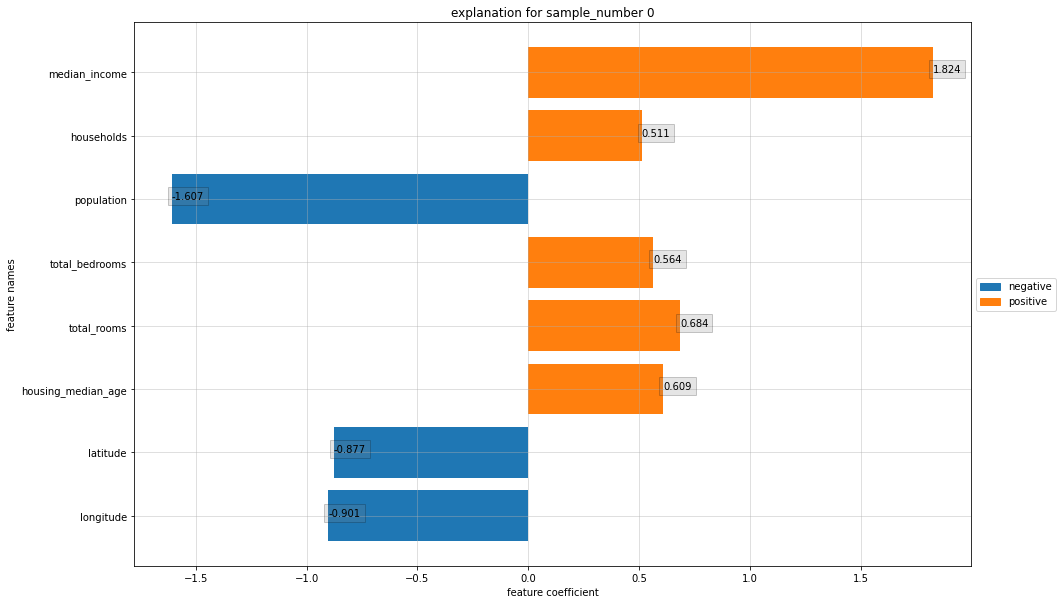

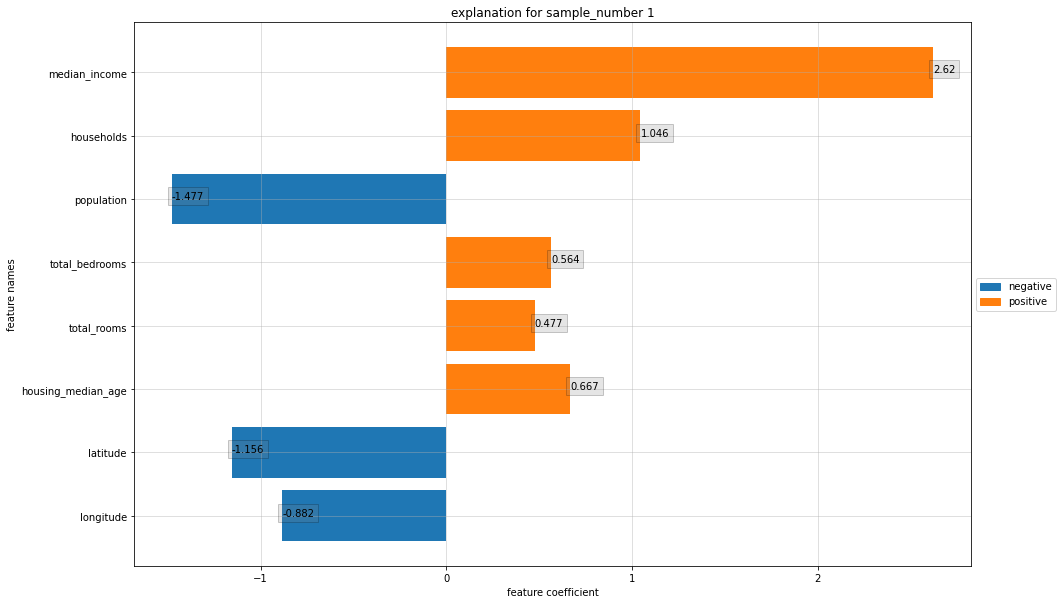

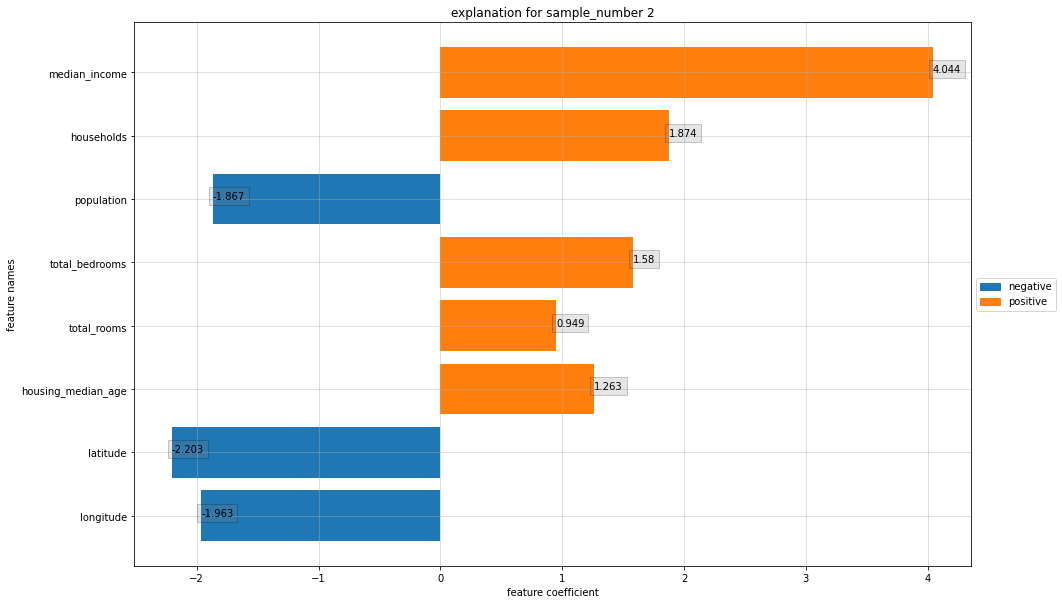

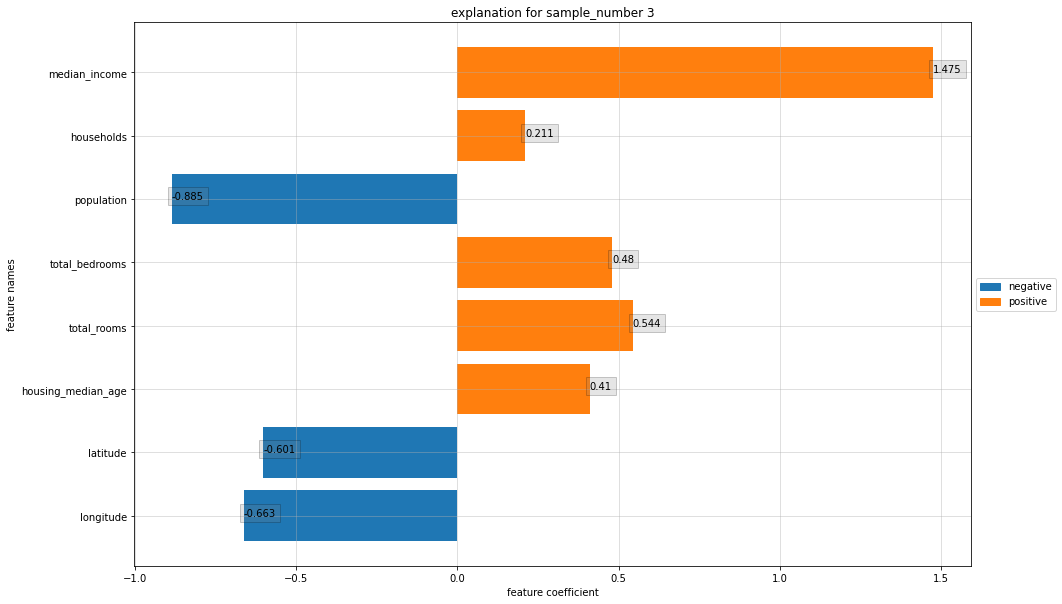

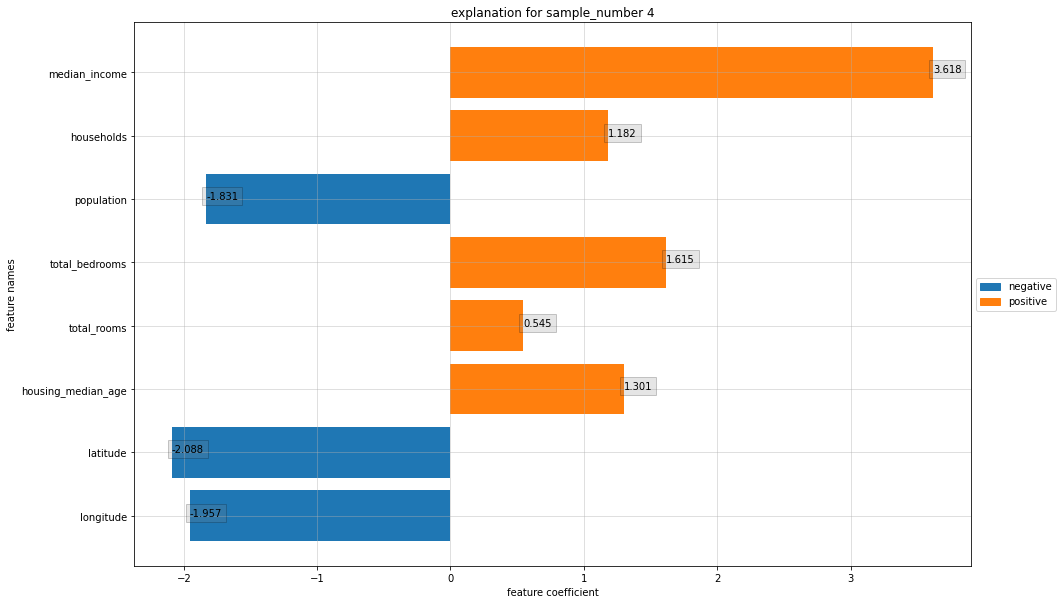

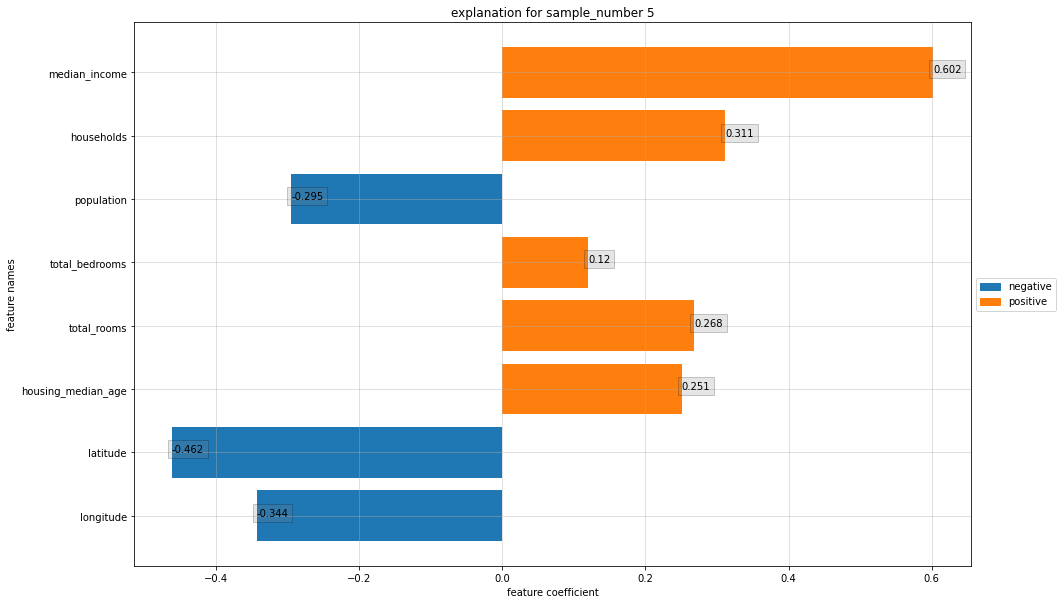

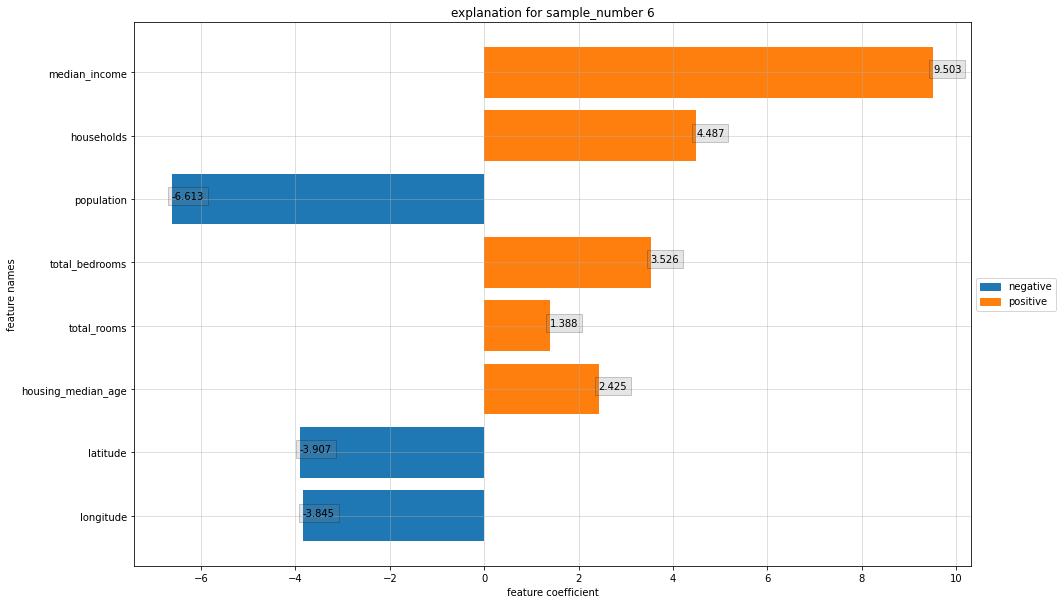

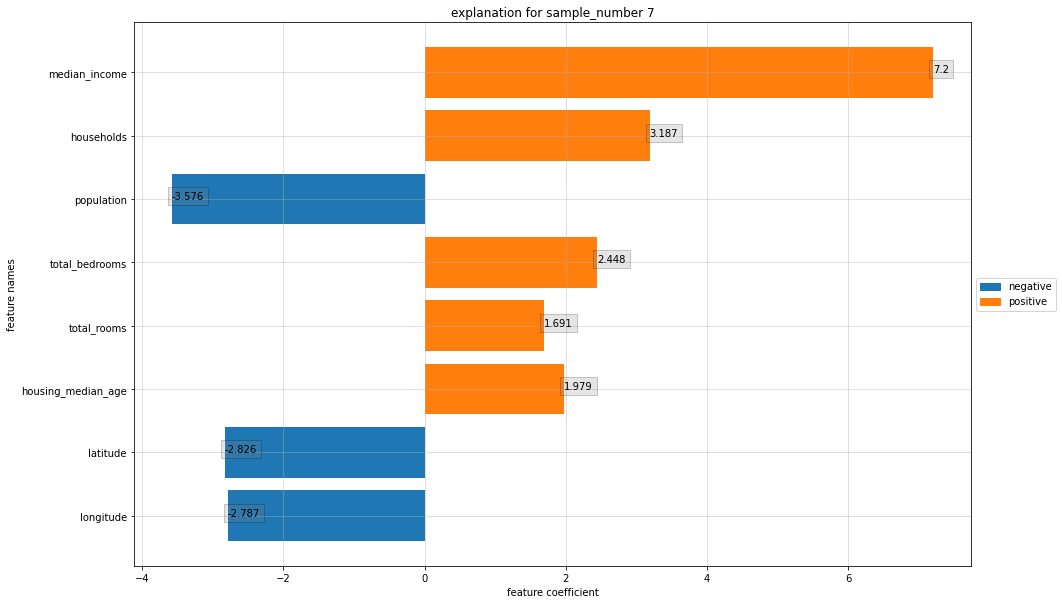

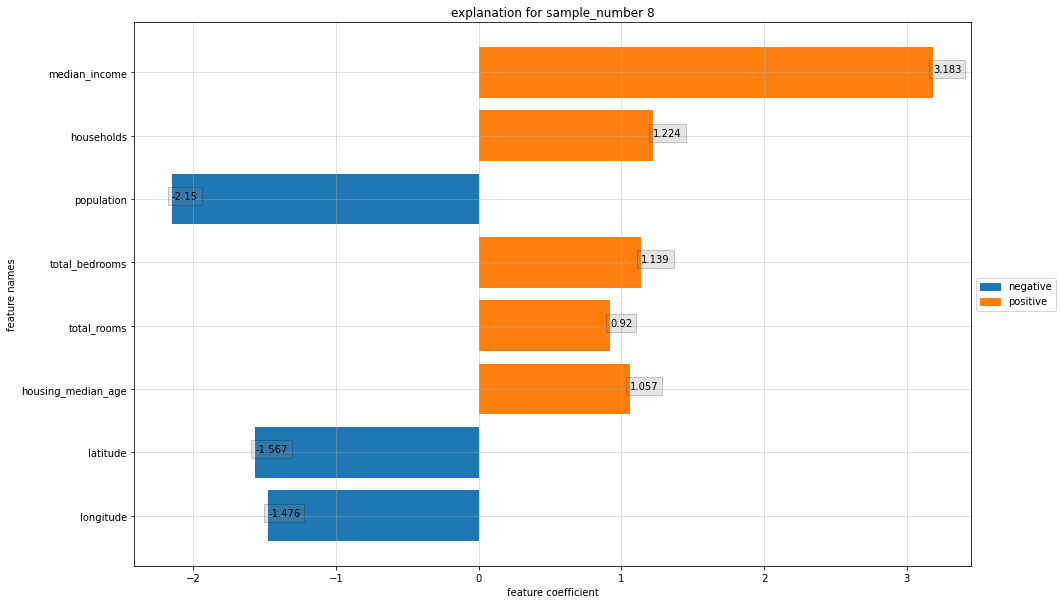

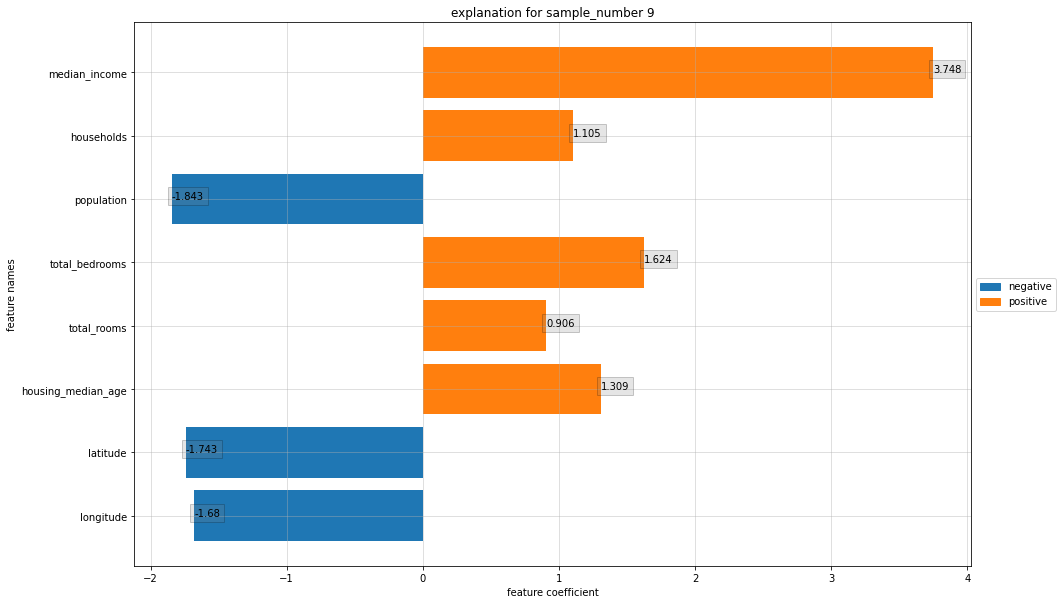

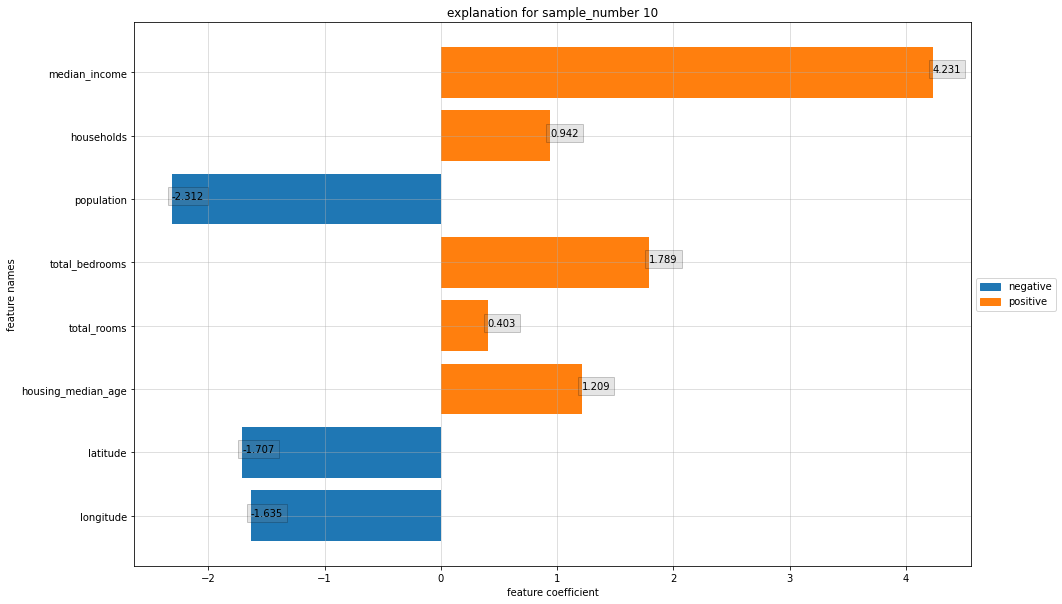

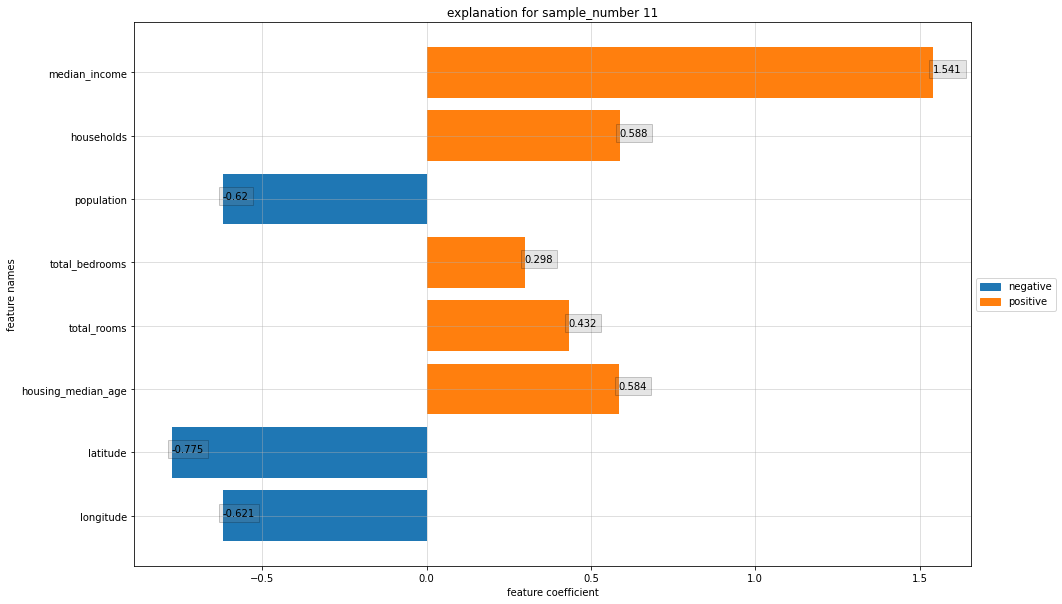

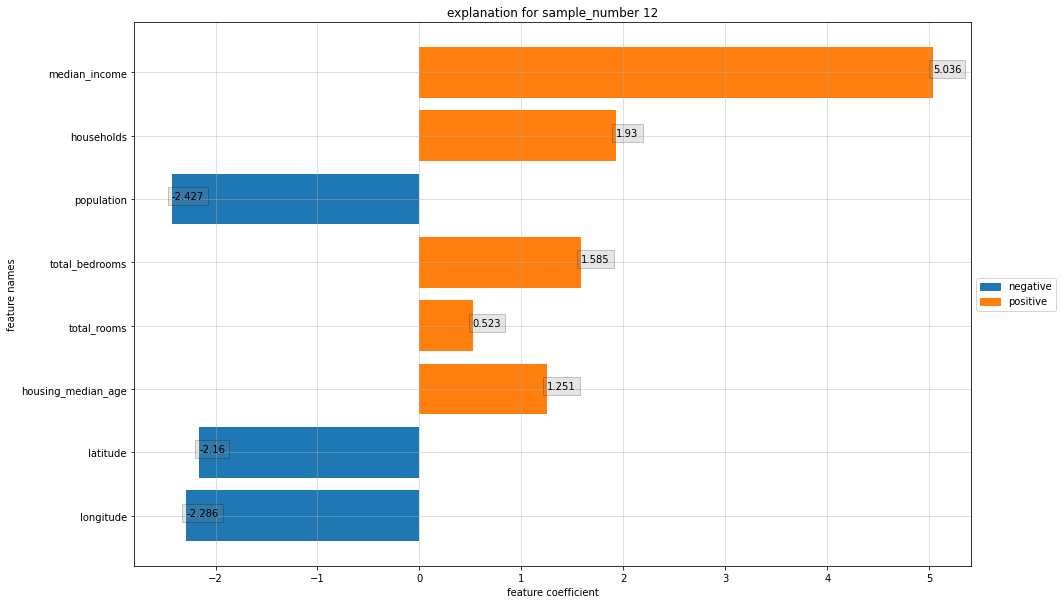

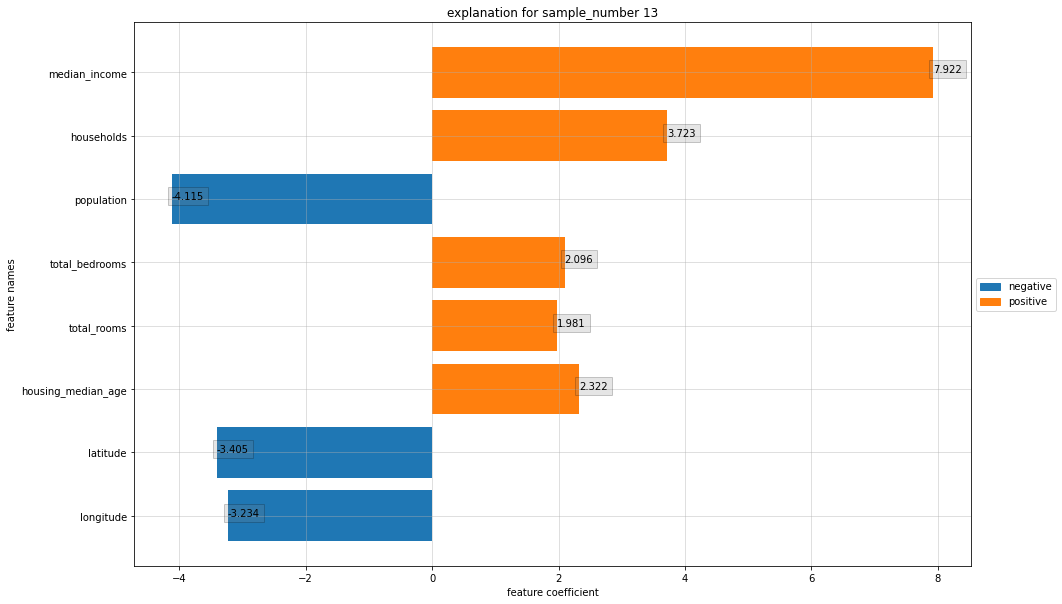

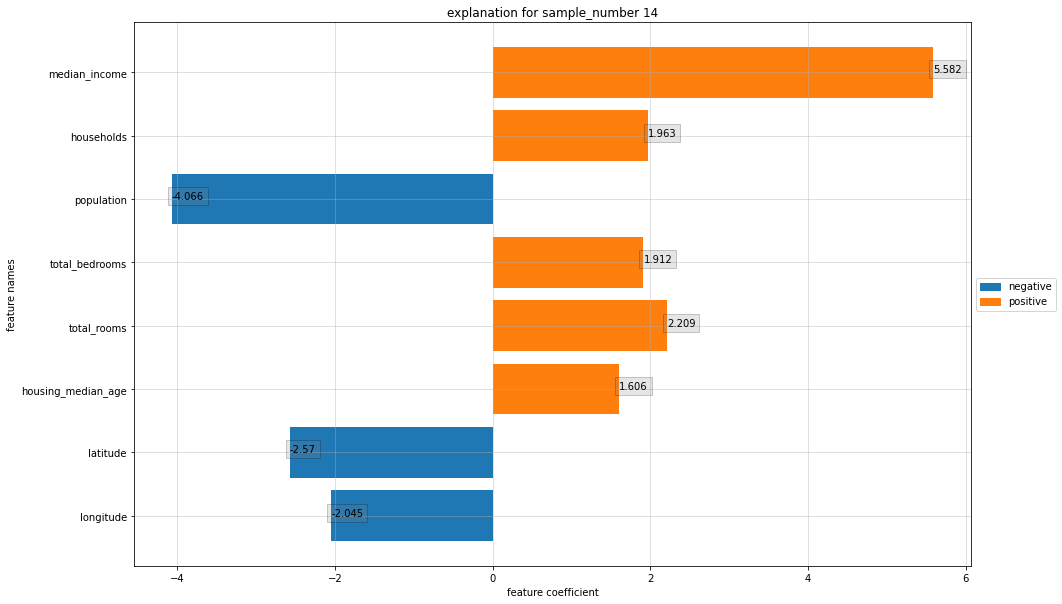

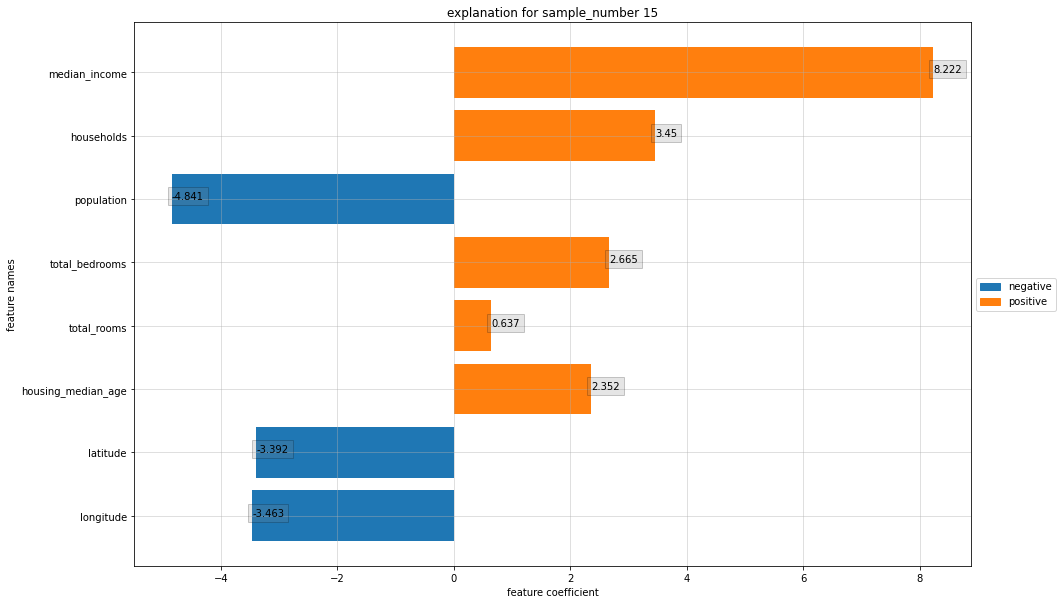

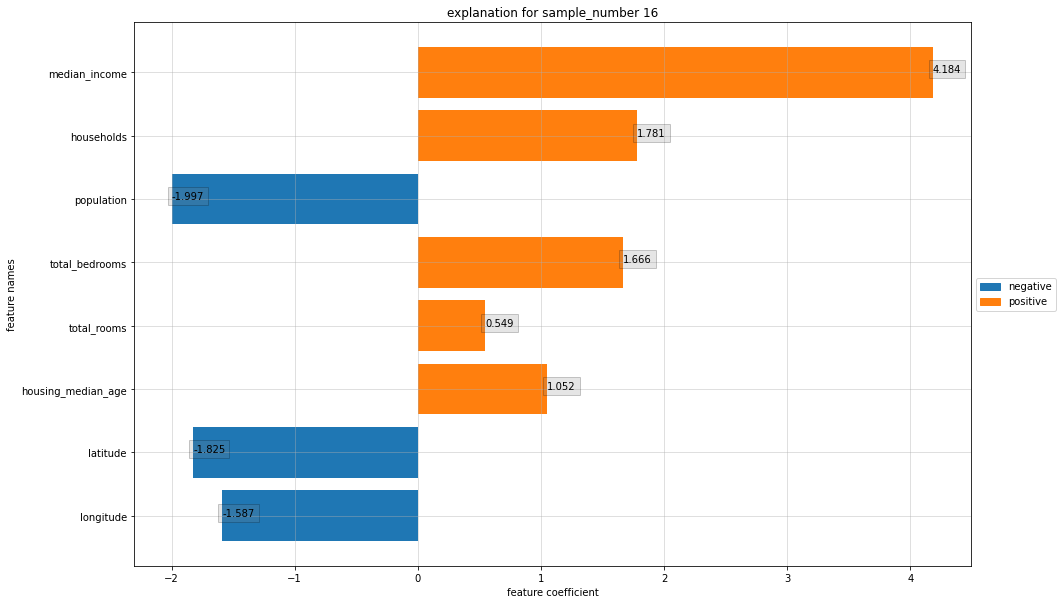

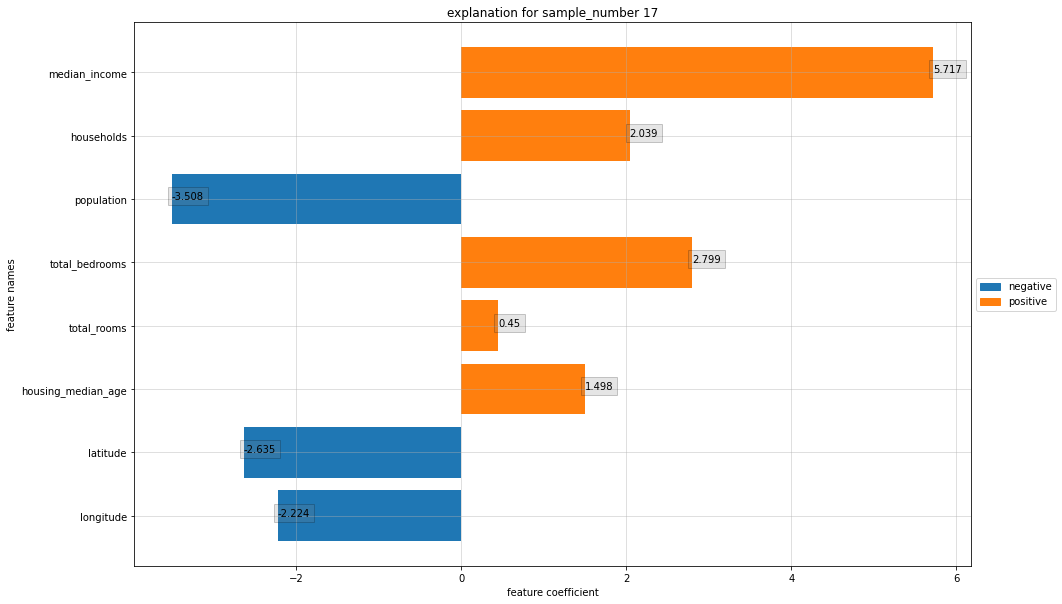

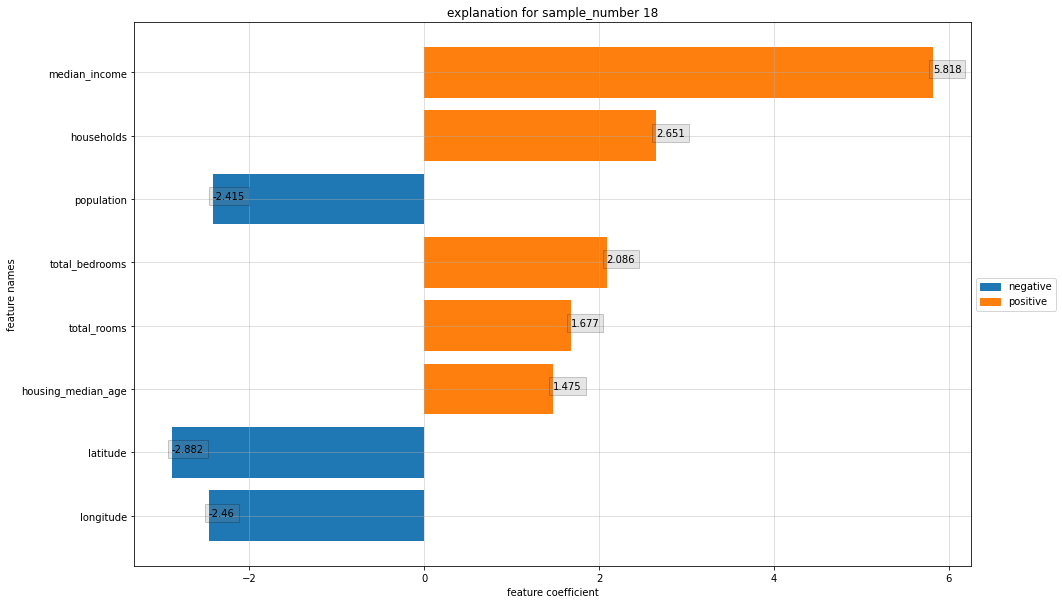

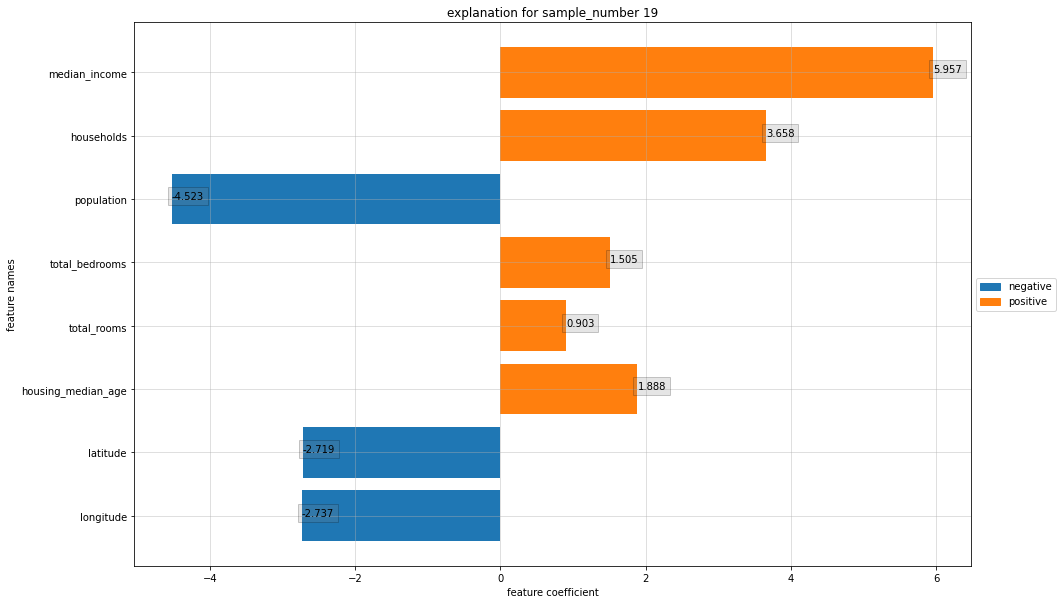

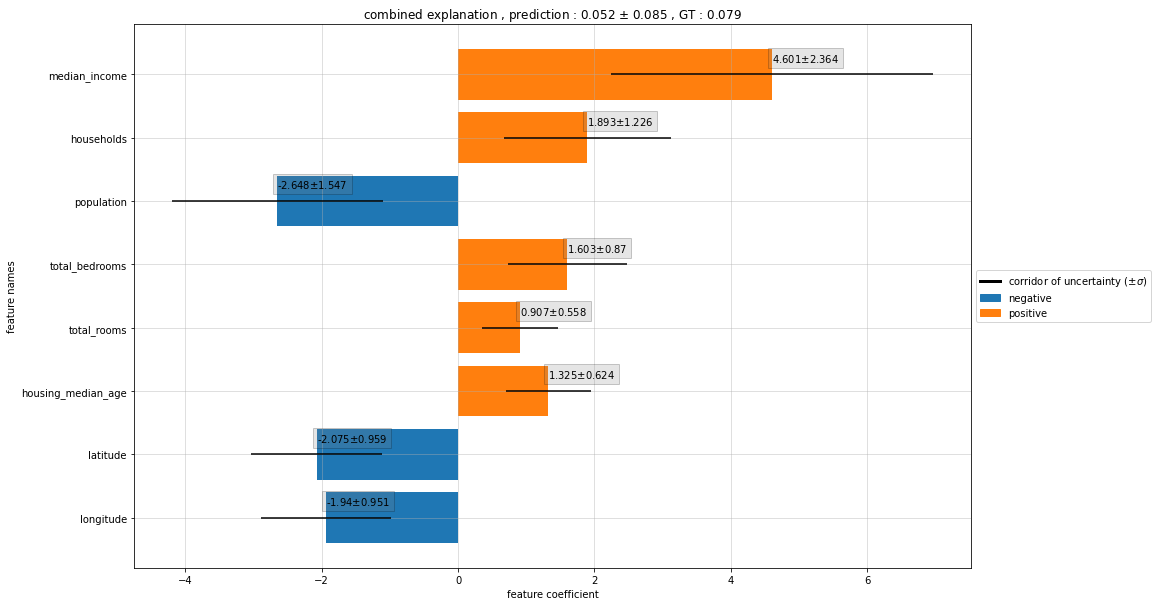

In [13]:
# Analysis of the input 
print('train data \n ', train_data[0])
print('feature names \n ', feature_names)

# Analysis of the input 
test_sample_index=np.random.randint(3000)
test_input_temp = test_data[test_sample_index]
test_input = np.expand_dims(test_input_temp, axis=0)
test_label = test_labels[test_sample_index] 


print('test_input shape :', test_input.shape)
print('test label shape : ', test_label.shape)
mean_feature_weight, std_feature_weight = gbp_explanation(test_input, 
                                                          test_label,
                                                          'flipout_dense_2',
                                                          stochastic_model, 
                                                          num_samples_explanations_to_be_generated=20,
                                                          sample_id=test_sample_index)

## Coefficient of Variation

mean_feature_weight  [-1.9395382  -2.0749516   1.3253222   0.90664136  1.6029173  -2.6483936
  1.8930666   4.601317  ]
std_feature_weight  [0.950722  0.958572  0.6241154 0.5582011 0.8698446 1.5465357 1.2257745
 2.3636692]
feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
coefficient_of_variation  [-49.017953872680664, -46.19731605052948, 47.09160029888153, 61.568015813827515, 54.266345500946045, -58.39523673057556, 64.75073099136353, 51.369404792785645]


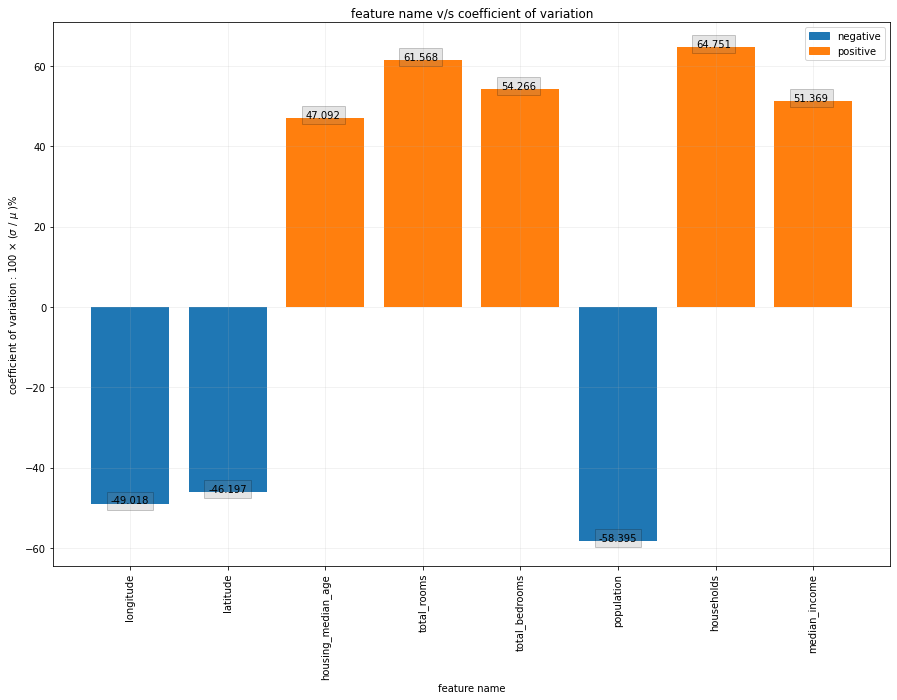

In [14]:
# coefficient of variation / relative standard deviation (RSD) (sigma divided by mu) 
# https://link.springer.com/chapter/10.1007/978-3-642-80328-4_13 [source that 30% cv could act as a threshold]
# https://en.wikipedia.org/wiki/Coefficient_of_variation
# https://www.formpl.us/blog/coefficient-variation

print('mean_feature_weight ', mean_feature_weight)
print('std_feature_weight ', std_feature_weight)
print('feature_names ', feature_names)

eps=1e-3
# compute coefficient of variation 
coefficient_of_variation = [100*(i/(j+eps)) if -0.001<j<0.001 else 100*(i/j) for i,j in zip(std_feature_weight, mean_feature_weight)]
print('coefficient_of_variation ', coefficient_of_variation)


plt.figure(figsize=(15, 10))
colors = ['C1' if x > 0 else 'C0' for x in list(coefficient_of_variation)] # originally negative=red and positive=green (coloring scheme)
colors_set = set(colors)
legend_colors = list(set(colors))
colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]

bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(colors_set))]
#uncomment the next 2 line in case cv threshold is needed 
#thresh = plt.plot([], label='threshold', linewidth=3, linestyle='-', color='k')
#handles = bars + thresh

main_bars_label = colors_set

# uncomment following two lines in case cv threshold is needed
#error_label = ['threshold']
#labels = main_bars_label + error_label 

# uncomment following two lines to remove threshold
handles = bars 
labels = main_bars_label

plt.bar(feature_names[:-1], coefficient_of_variation, color=colors)
# uncomment the following 2 lines to get the threshold lines
#plt.plot(feature_names[:-1], [30]*len(feature_names[:-1]), '--k')
#plt.plot(feature_names[:-1], [-30]*len(feature_names[:-1]), '--k')
plt.xticks(rotation=90)
plt.xlabel('feature name')
plt.ylabel(r'coefficient of variation : 100 $\times$ ($\sigma$ / $\mu$ )%')
plt.grid(alpha=0.2) 


plt.legend(handles, labels)
plt.title('feature name v/s coefficient of variation')

for i, v in enumerate(coefficient_of_variation):
    # in case the text box needs to be moved along the bar then switch 0 to v
    plt.text(i-0.2, v, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

plt.savefig(path+'output_plots/feature_name_vs_coefficient_of_variation_'+
            str(test_sample_index)+'.pdf', bbox_inches='tight')

plt.savefig(path+'output_plots/feature_name_vs_coefficient_of_variation_'+
            str(test_sample_index)+'.png', bbox_inches='tight')

#https://en.wikipedia.org/wiki/Kurtosis